In [2]:
import wrds
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *
from scipy import stats
import datetime as dt
import os
import config
import matplotlib.pyplot as plt
from base.utils import download_and_unzip

Device: cpu
Epochs: 200
Random seed set at: 21


In [3]:
conn = wrds.Connection()

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time
with the create_pgpass_file() function.
Loading library list...
Done


# Download tables

In [4]:
FF10Mom_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/10_Portfolios_Prior_12_2_CSV.zip'

if os.path.isfile(config.paths['FF10MomPortfoliosPath']) == False:
            download_and_unzip(FF10Mom_url, config.dataPath+'/external')
            print('Momentum portfolios downloaded from Kenneth French\'s library')

famafrench = pd.read_csv(config.paths['FF10MomPortfoliosPath'], skiprows=10, skipfooter = 3751 ,engine='python')
famafrench = famafrench.rename(columns={'Unnamed: 0': 'yyyymm'})


In [5]:
crsp = conn.raw_sql(
    """
    select a.permno, a.permco, a.date, a.ret, a.retx, a.vol, a.shrout, a.prc, a.cfacshr, a.bidlo, a.askhi,
    b.comnam, b.shrcd, b.exchcd, b.siccd, b.ticker, b.shrcls,          -- from identifying info table
    c.dlstcd, c.dlret                                                  -- from delistings table
    from crsp.msf as a
    left join crsp.msenames as b
    on a.permno=b.permno
    and b.namedt<=a.date
    and a.date<=b.nameendt
    left join crsp.msedelist as c
    on a.permno=c.permno
    and date_trunc('month', a.date) = date_trunc('month', c.dlstdt)
    where a.date between '01/01/1970' and '12/31/2021'
    """, 
    date_cols=['date'])

# Pre-processing

In [6]:
# Exclude entries in which a good price is missing
crsp = crsp.dropna(subset='prc')

# Exclude months in which the share code is missing
crsp = crsp.dropna(subset='shrcd')

In [7]:
# Move date to end of the month
crsp['date']=crsp['date']+MonthEnd(0)

# Create yearmonth column
crsp['yyyymm'] =  crsp['date'].apply(lambda x: dt.datetime.strftime(x, '%Y%m')) 
crsp['yyyymm'] = crsp.yyyymm.astype(int)

### Deal with de-listing returns

In [8]:
# following https://wrds-www.wharton.upenn.edu/pages/support/applications/python-replications/fama-french-factors-python/
crsp['dlret'] = crsp['dlret'].fillna(0)
crsp['ret'] = crsp['ret'].fillna(0)
crsp = crsp.loc[crsp['dlret'] != -1]
crsp['retadj'] = (1+crsp['ret'])*(1+crsp['dlret'])-1

crsp=crsp.drop(['dlret'], axis=1)

In [9]:
crsp_checkpoint = crsp.copy()

## Market equity adjustment
Calculate market equity for each permno, then merge the permnos with same permco, keep only the one with the largest permco

In [10]:
# calculate market equity
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
crsp=crsp.sort_values(by=['date','permco','me'])

### Aggregate Market Cap ###
# sum of me across different permno belonging to same permco in a given date
crsp_summe = crsp.groupby(['date','permco'])['me'].sum().reset_index()

# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['date','permco'])['me'].max().reset_index()



In [11]:
# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['date','permco','me'])

# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['date','permco'])

# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','date']).drop_duplicates()

In [12]:
crsp = crsp2.copy()

# Calculate melag and adjust for first month
crsp['count']=crsp.groupby(['permno']).cumcount()
crsp['melag'] = crsp.groupby('permno')['me'].shift()
crsp['melag'] = np.where(crsp['count'] == 0, crsp['me']/(1+crsp['retx']), crsp['melag']) # ret or retx?



### Filter for exchange code (1,2,3) and shrcd (10,11)

In [13]:
crsp = crsp.loc[(crsp['exchcd'].isin([1,2,3])) & (crsp.shrcd.isin([10,11]))]


# Calculate Momentum

In [14]:
_tmp_crsp = crsp[['permno','date','retadj']].sort_values(['permno','date']).set_index('date').copy()

# Replace missing return with 0
_tmp_crsp['retadj']=_tmp_crsp['retadj'].fillna(0)

# Calculate rolling cumulative return
# by summing log(1+ret) over the formation period
_tmp_crsp['logret']=np.log(1+_tmp_crsp['retadj'])
umd = _tmp_crsp.groupby(['permno'])['logret'].rolling(11).sum()
umd = umd.reset_index()
umd['cumret']=np.exp(umd['logret'])-1
umd.drop('logret', axis=1, inplace=True)
# Merge back to crsp
crsp = crsp.merge(umd, on=['permno','date'], how='left')


In [15]:
crsp = crsp.loc[(crsp['shrcd'].isin([10,11])) & (crsp['exchcd'].isin([1,2,3])) & (~crsp['melag'].isna())].copy()

# Calculating NYSE Mom breakpoints

In [16]:
crsp_nyse_mom = crsp.loc[crsp['exchcd'] == 1].copy()
crsp_nyse_mom = crsp_nyse_mom.loc[(crsp_nyse_mom['shrcd'].isin([10,11])) & (~crsp_nyse_mom['melag'].isna())].copy()

# Sort values by yyyymm
crsp_nyse_mom = crsp_nyse_mom.sort_values('yyyymm')
crsp_nyse_mom = crsp_nyse_mom.reset_index(drop=True)

In [17]:
crsp_nyse_mom['ret_t-12'] = crsp_nyse_mom.groupby('permno')['ret'].shift(12)
crsp_nyse_mom['prc_t-12'] = crsp_nyse_mom.groupby('permno')['prc'].shift(12)
crsp_nyse_mom['ret_t-1'] = crsp_nyse_mom.groupby('permno')['ret'].shift(1)
crsp_nyse_mom['date_t-12'] = (crsp_nyse_mom['date']  - pd.DateOffset(months=12))
crsp_nyse_mom['date_t-1'] = (crsp_nyse_mom['date']  - pd.DateOffset(months=1))

crsp_nyse_mom['date_t-1']=crsp_nyse_mom['date_t-1']+MonthEnd(0)
crsp_nyse_mom['date_t-12']=crsp_nyse_mom['date_t-12']+MonthEnd(0)

s = crsp_nyse_mom.groupby('permno').apply(lambda x: (x['date_t-1'].isin(x['date']) & (x['ret_t-1'] != -0.99) & (~x['ret_t-1'].isna())))
crsp_nyse_mom['t-1_check'] = s.reset_index(level=0)[0]
s = crsp_nyse_mom.groupby('permno').apply(lambda x: (x['date_t-12'].isin(x['date'])))# & (~x['prc_t-12'].isna()))
crsp_nyse_mom['present_t-12'] = s.reset_index(level=0)['date_t-12']#[0]

In [18]:
crsp_nyse_mom['mom'] = crsp_nyse_mom.groupby('permno')['cumret'].shift(2)

# Select valid rows only, according to Fama & French the stock must have a valid return in 
crsp_nyse_mom= crsp_nyse_mom.loc[(crsp_nyse_mom['present_t-12'] == True) & (crsp_nyse_mom['t-1_check'] == True)].copy()

In [19]:
crsp_nyse_mom = crsp_nyse_mom.drop(['permco', 'retx', 'vol', 'shrout', 'prc',
       'cfacshr', 'bidlo', 'askhi', 'comnam', 'shrcd', 'exchcd', 'siccd',
       'ticker', 'shrcls', 'dlstcd', 'retadj', 'count',
       'ret_t-12', 'prc_t-12', 'ret_t-1', 'date_t-12',
       'date_t-1', 't-1_check', 'present_t-12'],axis=1,errors='ignore')

## Calculate decile NYSE breakpoints

In [20]:
deciles = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
for i,decile in enumerate(deciles):
    if i == 0:
        mom_breakpoints = crsp_nyse_mom.groupby('yyyymm')['mom'].quantile(.1).reset_index(drop=False).copy()
        mom_breakpoints = mom_breakpoints.rename({'mom': "mom_nyse10"}, axis=1)
    else:
        mom_breakpoints['mom_nyse'+str(int(decile*100))] = crsp_nyse_mom.groupby('yyyymm')['mom'].quantile(decile).reset_index(drop=True)

mom_breakpoints.head(5)

,yyyymm,mom_nyse10,mom_nyse20,mom_nyse30,mom_nyse40,mom_nyse50,mom_nyse60,mom_nyse70,mom_nyse80,mom_nyse90
0,197101,-0.452419,-0.343072,-0.253159,-0.165063,-0.101374,-0.032538,0.023059,0.094795,0.215139
1,197102,-0.361178,-0.224685,-0.116548,-0.031424,0.049769,0.106334,0.167781,0.254338,0.365161
2,197103,-0.272659,-0.160155,-0.068245,0.005587,0.066166,0.125239,0.179682,0.247092,0.372939
3,197104,-0.230515,-0.113125,-0.026170,0.038255,0.088904,0.142008,0.196020,0.277411,0.435610
4,197105,-0.028768,0.082810,0.148437,0.208696,0.271316,0.341525,0.431011,0.559779,0.745568


## Portfolio - prep phase

In [21]:
# crsp = crsp.loc[(crsp['shrcd'].isin([10,11])) & (crsp['exchcd'].isin([1,2,3])) & (~crsp['melag'].isna())].copy()

In [22]:
crsp = crsp.sort_values('yyyymm')
crsp = crsp.reset_index(drop=True)

crsp['ret_t-12'] = crsp.groupby('permno')['ret'].shift(12)
crsp['prc_t-12'] = crsp.groupby('permno')['prc'].shift(12)
crsp['ret_t-1'] = crsp.groupby('permno')['ret'].shift(1)
crsp['date_t-12'] = (crsp['date']  - pd.DateOffset(months=12))
crsp['date_t-1'] = (crsp['date']  - pd.DateOffset(months=1))

crsp['date_t-1'] = crsp['date_t-1']+MonthEnd(0)
crsp['date_t-12'] = crsp['date_t-12']+MonthEnd(0)

s = crsp.groupby('permno').apply(lambda x: (x['date_t-1'].isin(x['date']) & (x['ret_t-1'] != -0.99) & (~x['ret_t-1'].isna())))
crsp['t-1_check'] = s.reset_index(level=0)[0]
s = crsp.groupby('permno').apply(lambda x: (x['date_t-12'].isin(x['date'])))# & (~x['prc_t-12'].isna()))
crsp['present_t-12'] = s.reset_index(level=0)['date_t-12']#[0]

In [23]:
crsp['mom'] = crsp.groupby('permno')['cumret'].shift(2)

# Select valid rows only, according to Fama & French the stock must have a valid return in 
crsp = crsp.loc[(crsp['present_t-12'] == True) & (crsp['t-1_check'] == True)].copy()

In [24]:
crsp = crsp.drop(['permco', 'retx', 'vol', 'shrout', 'prc',
       'cfacshr', 'bidlo', 'askhi', 'comnam', 'shrcd', 'exchcd', 'siccd',
       'ticker', 'shrcls', 'dlstcd', 'retadj', 'count',
       'ret_t-12', 'prc_t-12', 'ret_t-1', 'date_t-12',
       'date_t-1', 't-1_check', 'present_t-12'],axis=1,errors='ignore')

In [25]:
crsp = crsp.dropna(subset='mom')

In [26]:
crsp.head()

,permno,date,ret,yyyymm,me,melag,cumret,mom
26991,22496.0,1971-01-31,-0.004545,197101,525873.750,528275.00,0.158437,1.025910e-01
26992,19887.0,1971-01-31,0.064286,197101,28961.875,27212.50,0.179100,-2.593391e-01
26993,46420.0,1971-01-31,0.317881,197101,73580.250,55832.25,0.859813,-6.861084e-10
26994,17144.0,1971-01-31,-0.000916,197101,616882.500,621627.75,-0.054285,-4.799693e-02
26995,41777.0,1971-01-31,-0.035714,197101,53409.375,55387.50,-0.550000,-7.425150e-01


From now on, there will be two different methods for calculating portfolio returns, and the relative correlation

In [27]:
crsp_checkpoint = crsp.copy()

# Portfolio Formation

In [28]:
crsp = crsp_checkpoint.copy()

crsp = crsp.merge(mom_breakpoints, on='yyyymm', how='left')

conditions =[
    (crsp['mom'] < crsp['mom_nyse10']),
    ((crsp['mom'] >= crsp['mom_nyse10']) & (crsp['mom'] < crsp['mom_nyse20'])),
    ((crsp['mom'] >= crsp['mom_nyse20']) & (crsp['mom'] < crsp['mom_nyse30'])),
    ((crsp['mom'] >= crsp['mom_nyse30']) & (crsp['mom'] < crsp['mom_nyse40'])),
    ((crsp['mom'] >= crsp['mom_nyse40']) & (crsp['mom'] < crsp['mom_nyse50'])),
    ((crsp['mom'] >= crsp['mom_nyse50']) & (crsp['mom'] < crsp['mom_nyse60'])),
    ((crsp['mom'] >= crsp['mom_nyse60']) & (crsp['mom'] < crsp['mom_nyse70'])),
    ((crsp['mom'] >= crsp['mom_nyse70']) & (crsp['mom'] < crsp['mom_nyse80'])),
    ((crsp['mom'] >= crsp['mom_nyse80']) & (crsp['mom'] < crsp['mom_nyse90'])),
    (crsp['mom'] >= crsp['mom_nyse90'])
]
values = [1,2,3,4,5,6,7,8,9,10]

crsp['decile'] = np.select(conditions, values)


# Filters
crsp = crsp.loc[
    (pd.notnull(crsp['me'])) & 
    (pd.notnull(crsp['yyyymm']))
    ].copy()
    
crsp = crsp.sort_values(by=['permno','yyyymm'])


# Create portfolio weights
weight = pd.DataFrame(crsp.groupby(['yyyymm','decile'])['melag'].sum()).reset_index(drop=False)
weight = weight.rename(columns={'melag':'total_melag'})
crsp = pd.merge(crsp,weight,on=['yyyymm','decile'], how='inner')
crsp['weight'] = crsp['melag'] / crsp['total_melag']


# Calculate portfolio returns
crsp = (crsp.sort_values(by=['permno','yyyymm'])).reset_index(drop=True)
crsp['vw_ret'] = crsp['ret'] * crsp['weight']#.shift()  #use shift to get last periods value weight
crsp.loc[crsp['permno'] != crsp['permno'].shift(), 'vw_ret'] = np.nan



# Create returns portfolio
monthly_vw = crsp.groupby(['yyyymm','decile'])['vw_ret'].sum()
monthly_vw = monthly_vw.unstack('decile')
monthly_vw = monthly_vw.reset_index(drop=False)
monthly_vw = monthly_vw.iloc[1:,:]
monthly_vw.head()

decile,yyyymm,1,2,3,4,5,6,7,8,9,10
1,197102,0.046445,-0.001167,0.017459,0.021642,0.020502,-0.006640,0.017716,0.013218,0.014590,0.039702
2,197103,0.081166,0.063821,0.057477,0.059627,0.022430,0.037346,0.028990,0.039976,0.031772,0.052451
3,197104,0.036609,0.024715,0.044024,0.003807,0.033663,0.037612,0.041600,0.052352,0.052829,0.049554
4,197105,-0.057977,-0.047111,-0.018383,-0.032845,-0.052578,-0.022799,-0.026228,-0.057063,-0.028264,-0.030036
5,197106,-0.030078,0.000547,0.015318,0.000102,-0.000439,-0.001307,0.001161,-0.003027,0.024499,0.025215


### Method 1

### Compare deciles with momentum portfolios

In [36]:
famafrench = famafrench.loc[(famafrench.yyyymm >= monthly_vw.yyyymm.min()) & (famafrench.yyyymm <= monthly_vw.yyyymm.max())]
port_correlations = []
for i in range(1,11):
    port_corr = stats.pearsonr(monthly_vw.iloc[:,i], famafrench.iloc[:,i])
    port_correlations.append(round(port_corr[0]*100,1))
    print(f'Mom returns correlation, decile {i}: {round(port_corr[0]*100,1)}%')    
    mean_replication = monthly_vw.iloc[:,i].mean()
    mean_ff = famafrench.iloc[:,i].mean()
    stdev_replication = monthly_vw.iloc[:,i].std()
    stdev_ff = famafrench.iloc[:,i].std()
    print(f'Decile {i}:\nMean:\t\tReplication: {mean_replication*100:.2f}\tFF: {mean_ff:.2f}\nStd. Dev:\tReplication:{stdev_replication*100:.2f}\tFF: {stdev_ff:.2f}')
print(f'Average correlation: {np.mean(port_correlations)}%')

Mom returns correlation, decile 1: 99.9%
Decile 1:
Mean:		Replication: 0.32	FF: 0.34
Std. Dev:	Replication:8.52	FF: 8.61
Mom returns correlation, decile 2: 99.9%
Decile 2:
Mean:		Replication: 0.77	FF: 0.78
Std. Dev:	Replication:6.50	FF: 6.55
Mom returns correlation, decile 3: 99.7%
Decile 3:
Mean:		Replication: 0.93	FF: 0.91
Std. Dev:	Replication:5.53	FF: 5.52
Mom returns correlation, decile 4: 99.6%
Decile 4:
Mean:		Replication: 1.01	FF: 1.04
Std. Dev:	Replication:4.98	FF: 4.96
Mom returns correlation, decile 5: 99.7%
Decile 5:
Mean:		Replication: 0.94	FF: 0.93
Std. Dev:	Replication:4.53	FF: 4.54
Mom returns correlation, decile 6: 99.7%
Decile 6:
Mean:		Replication: 0.98	FF: 1.01
Std. Dev:	Replication:4.56	FF: 4.58
Mom returns correlation, decile 7: 99.6%
Decile 7:
Mean:		Replication: 1.02	FF: 1.03
Std. Dev:	Replication:4.43	FF: 4.42
Mom returns correlation, decile 8: 99.7%
Decile 8:
Mean:		Replication: 1.10	FF: 1.11
Std. Dev:	Replication:4.44	FF: 4.46
Mom returns correlation, decile 

In [30]:
monthly_vw_cumret = monthly_vw.copy()
monthly_vw_cumret.iloc[:,1:] = np.log(1+monthly_vw_cumret.iloc[:,1:]).cumsum()
monthly_vw_cumret['date'] = monthly_vw_cumret['yyyymm'].apply(lambda x: dt.datetime.strptime(str(x), '%Y%m'))
monthly_vw_cumret['date'] = monthly_vw_cumret.date + MonthEnd(0)
monthly_vw_cumret = monthly_vw_cumret.set_index(monthly_vw_cumret['date'])
monthly_vw_cumret.drop('date',axis=1, inplace=True)

famafrench_cumret = famafrench.copy()
famafrench_cumret.iloc[:,1:] = np.log(1+famafrench_cumret.iloc[:,1:]/100).cumsum()
famafrench_cumret['date'] = famafrench_cumret['yyyymm'].apply(lambda x: dt.datetime.strptime(str(x), '%Y%m'))
famafrench_cumret['date'] = famafrench_cumret.date + MonthEnd(0)
famafrench_cumret = famafrench_cumret.set_index(famafrench_cumret['date'])
famafrench_cumret.drop('date',axis=1, inplace=True)

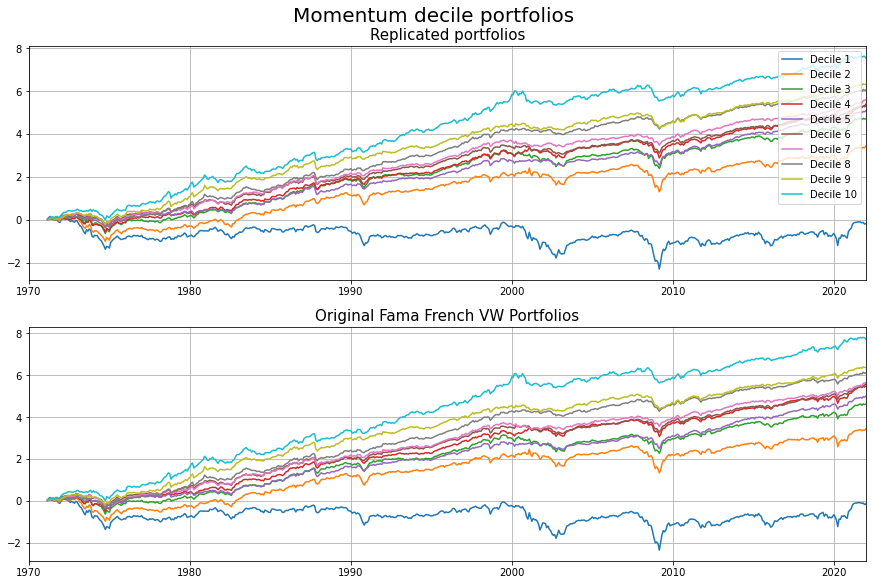

In [31]:
plt.figure(figsize=(15,9))
plt.suptitle('Momentum decile portfolios', fontsize=20)
ax1 = plt.subplot(211)
ax1.set_title('Replicated portfolios', fontsize=15)
ax1.set_xlim([dt.datetime(1970,1,1), dt.datetime(2021,12,31)])
ax1.plot(monthly_vw_cumret.iloc[:,1:])
ax1.legend((
    'Decile 1',
    'Decile 2',
    'Decile 3',
    'Decile 4',
    'Decile 5',
    'Decile 6',
    'Decile 7',
    'Decile 8',
    'Decile 9',
    'Decile 10'),loc='upper right')
ax2 = plt.subplot(212)
ax2.set_title('Original Fama French VW Portfolios', fontsize=15)
ax2.plot(famafrench_cumret.iloc[:,1:])
ax2.set_xlim([dt.datetime(1970,1,1), dt.datetime(2021,12,31)])
ax1.legend((
    'Decile 1',
    'Decile 2',
    'Decile 3',
    'Decile 4',
    'Decile 5',
    'Decile 6',
    'Decile 7',
    'Decile 8',
    'Decile 9',
    'Decile 10'),loc='upper right')

# ax2.set_title('Comparison with Fama-French UMD', fontsize=15)
# ax2.plot(momentum_check['mom'], 'b-', momentum_check['umd'], 'r-')
# ax2.set_xlim([dt.datetime(1970,1,1), dt.datetime(2021,12,31)])
# ax2.legend(('Replication','FF_UMD'), loc='upper left', shadow=True)
ax1.grid()
ax2.grid()
plt.subplots_adjust(top=0.92, hspace=0.2)

In [32]:
monthly_vw_checkpoint = monthly_vw.copy()
famafrench_checkpoint = famafrench.copy()

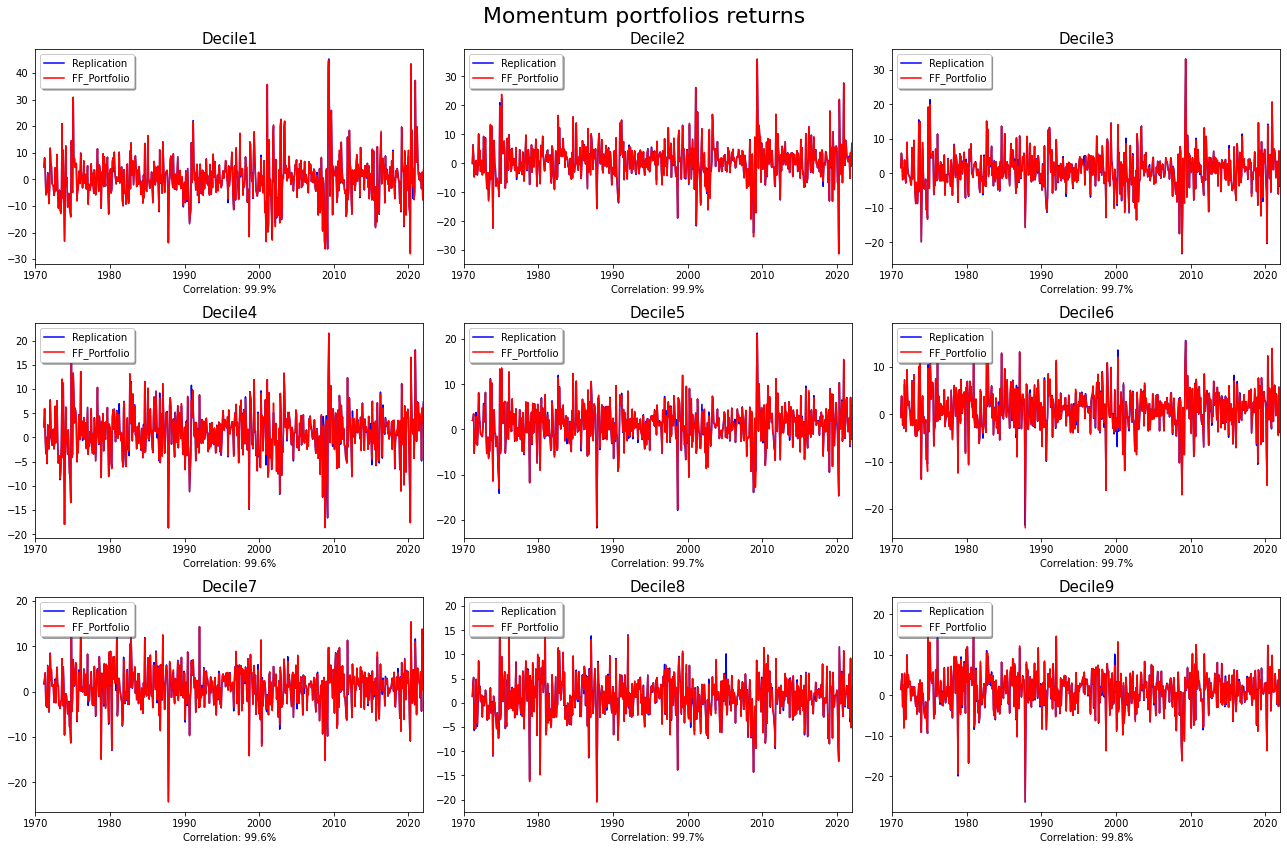

In [33]:
famafrench = famafrench_checkpoint.copy()
monthly_vw = monthly_vw_checkpoint.copy()

monthly_vw['date'] = monthly_vw['yyyymm'].apply(lambda x: dt.datetime.strptime(str(x), '%Y%m'))
monthly_vw['date'] = monthly_vw.date + MonthEnd(0)
monthly_vw = monthly_vw.set_index(monthly_vw['date'])
monthly_vw.drop('date',axis=1, inplace=True)

famafrench['date'] = famafrench['yyyymm'].apply(lambda x: dt.datetime.strptime(str(x), '%Y%m'))
famafrench['date'] = famafrench.date + MonthEnd(0)
famafrench = famafrench.set_index(famafrench['date'])
famafrench.drop('date',axis=1, inplace=True)

plt.figure(figsize=(18,12))
plt.suptitle('Momentum portfolios returns', fontsize=22)
for i in range(1,len(monthly_vw.columns.tolist())-1):
    ax1 = plt.subplot(3,3,i)
    ax1.set_title('Decile'+str(i), fontsize=15)
    # ax1.text(dt.datetime(2015,12,31),monthly_vw.iloc[:,i].max()*0.95,'Correlation')
    port_corr = round(stats.pearsonr(monthly_vw.iloc[:,i], famafrench.iloc[:,i])[0]*100,1)
    plt.xlabel('Correlation: ' + str(port_corr) + '%')
    ax1.set_xlim([dt.datetime(1970,1,1), dt.datetime(2021,12,31)])
    ax1.plot(monthly_vw.iloc[:,i]*100, 'b-')
    ax1.plot(famafrench.iloc[:,i], 'r-')
    ax1.legend(('Replication','FF_Portfolio'), loc='upper left', shadow=True)
plt.tight_layout()
# plt.subplots_adjust(top=0.92, hspace=0.2)